<a href="https://colab.research.google.com/github/cgjeong23/Deep-Learning-Pratice/blob/main/Astros_Statistical_Test_and_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

## Data Preprocessing

In [36]:
df = pd.read_csv("/content/drive/MyDrive/fixed_data.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,game_date,home_team,away_team,is_day_game,home_score,away_score,venue,venue_name,city,state,away_pa,away_1b,away_2b,away_3b,away_hr,away_fo,away_so,away_bb,away_hbp,home_pa,home_1b,home_2b,home_3b,home_hr,home_fo,home_so,home_bb,home_hbp,home_OBP,away_OBP,home_AVG,away_AVG,home_SLG,away_SLG,home_OPS,away_OPS,season,lgOPB,lgSLG,home_OPS+,away_OPS+,away_team_season_SLG,away_team_season_OBP,home_team_season_SLG,home_team_season_OBP,home_team_season_OPS+,away_team_season_OPS+,home_won,away_won,away_distance,away_longitude,away_gap,home_distance,home_longitude,home_gap,away_did_travel,home_did_travel,game_tz
0,0,0,2000-03-29,NYN,CHN,False,3,5,TOK01,Tokyo Dome,Tokyo,JAP,45,9,1,0,2,17,5,10,1,38,5,1,0,1,24,4,3,0,0.263158,0.511111,0.184211,0.266667,0.289474,0.422222,0.552632,0.933333,2000,0.334523,0.376971,55.455850,164.791705,0.35192,0.323658,0.364148,0.334958,96.728346,90.106367,0,1,0,0.0000,True,0,0.0000,True,0,0,16.0
1,1,251,2000-04-22,NYN,CHN,True,8,3,NYC17,Shea Stadium,New York,NY,36,5,1,0,2,22,5,1,0,41,9,3,0,0,19,3,6,1,0.463415,0.250000,0.292683,0.222222,0.365854,0.416667,0.829268,0.666667,2000,0.334523,0.376971,135.580650,85.263281,0.35192,0.323658,0.364148,0.334958,96.728346,90.106367,1,0,536769,-0.3632,True,0,0.0000,True,1,0,6.0
2,3,252,2000-04-22,NYN,CHN,True,7,6,NYC17,Shea Stadium,New York,NY,42,6,4,0,1,21,5,4,1,37,6,3,0,1,14,6,7,0,0.459459,0.380952,0.270270,0.261905,0.432432,0.428571,0.891892,0.809524,2000,0.334523,0.376971,152.059813,127.567252,0.35192,0.323658,0.364148,0.334958,96.728346,90.106367,1,0,536769,-0.3632,True,0,0.0000,True,1,0,6.0
3,5,266,2000-04-23,NYN,CHN,True,15,8,NYC17,Shea Stadium,New York,NY,42,4,4,0,2,24,4,4,0,45,11,4,0,3,16,9,2,0,0.444444,0.333333,0.400000,0.238095,0.688889,0.476190,1.133333,0.809524,2000,0.334523,0.376971,215.602091,125.964361,0.35192,0.323658,0.364148,0.334958,96.728346,90.106367,1,0,0,0.0000,False,0,0.0000,False,0,0,6.0
4,6,563,2000-05-16,NYN,COL,False,3,4,NYC17,Shea Stadium,New York,NY,44,6,2,0,1,17,14,4,0,44,6,4,0,2,22,7,3,0,0.340909,0.295455,0.272727,0.204545,0.500000,0.318182,0.840909,0.613636,2000,0.334523,0.376971,134.545008,72.725849,0.39054,0.349814,0.364148,0.334958,96.728346,108.170283,0,1,0,0.0000,True,2618935,30.9509,True,0,1,6.0


Only taking essential variales needed for the model.  
-**game_date**: The date game is played  
-**home_team/away_team**: The home team and away team for each game  
-**home_distance**: How much the home team travelled from the previous game location   
-**away_distance**: How much the away team travelled from the previous game location  
-**home_OPS+**: On-Base Plus Slugging for home team  
-**away_OPS+**: On-Base Plus Slugging for away team

In [37]:
df = df[['game_date', 'home_team', 'away_team', 'home_distance', 'away_distance','home_OPS+', 'away_OPS+']].copy()
df.head()

,game_date,home_team,away_team,home_distance,away_distance,home_OPS+,away_OPS+
0,2000-03-29,NYN,CHN,0,0,55.455850,164.791705
1,2000-04-22,NYN,CHN,0,536769,135.580650,85.263281
2,2000-04-22,NYN,CHN,0,536769,152.059813,127.567252
3,2000-04-23,NYN,CHN,0,0,215.602091,125.964361
4,2000-05-16,NYN,COL,2618935,0,134.545008,72.725849


Changing the date to the datetime object

In [38]:
from datetime import datetime
df['game_date'] = pd.to_datetime(df['game_date'], format='%Y-%m-%d')

#### Testing to see if we can extract consecutive travel_distance / OPS data for a single team in a single season

In [39]:
#New York Yankess for example
from datetime import datetime
NYN = df.loc[(df['home_team'] == 'NYN') | (df['away_team'] == 'NYN')]
NYN.groupby(NYN['game_date'].dt.year)

NYN.head()

,game_date,home_team,away_team,home_distance,away_distance,home_OPS+,away_OPS+
0,2000-03-29,NYN,CHN,0,0,55.455850,164.791705
1,2000-04-22,NYN,CHN,0,536769,135.580650,85.263281
2,2000-04-22,NYN,CHN,0,536769,152.059813,127.567252
3,2000-04-23,NYN,CHN,0,0,215.602091,125.964361
4,2000-05-16,NYN,COL,2618935,0,134.545008,72.725849


In [40]:
first_season = NYN[(NYN['game_date'] > '2001-1-1') & (NYN['game_date'] < '2002-1-1')]
len(first_season)

162

In [41]:
first_season.reset_index(drop=True, inplace=True)
print(first_season['home_distance'])

#There is 162 game, meaning we successfully extracted the games for a single team in a single season

0      1799707
1            0
2            0
3            0
4            0
        ...   
157          0
158          0
159          0
160          0
161          0
Name: home_distance, Length: 162, dtype: int64


#### Shifting the dataframe so each row is a consecutive travel_distance / OPS for each team in a each season

In [42]:
ts_dist_df = pd.DataFrame(columns=[str(i) for i in range(164)])
ts_ops_df = pd.DataFrame(columns=[str(i) for i in range(164)])
ts_date_df = pd.DataFrame(columns=[str(i) for i in range(164)])


#Dictionary of team initials to make dataframe with games only for that team
team_list = ["SFN","CHN","PHI","ANA","MIL","SDN","MIN","TEX","LAN","OAK",
             "BOS","COL","CHA","TBA","ARI","CIN","SEA","ATL","NYA","PIT",
             "BAL", "NYN","KCA","SLN","CLE","HOU","DET","TOR","WAS","FLO",
             "MIA","MON"]


#Iterating througout every team
for team in team_list:
    #Including both the consecutive home games and away games
    team_data = df.loc[(df['home_team'] == team) | (df['away_team'] == team)]
    team_data.reset_index(drop=True, inplace=True)

    #Iterating for each season for that team
    for season in range(24):
      #Grouping data for specific year
      season_data = team_data.copy()
      season_data['Year'] = team_data['game_date'].dt.year.astype(int)
      season_data = season_data[season_data['Year'] == (2000+season)]

      #Including team name and the season
      season_data['distance'] = season_data.apply(lambda row: row['home_distance'] if team == row['home_team'] else row['away_distance'], axis=1)
      season_distance_data = season_data['distance'].tolist()
      season_distance_data.insert(0, team)
      season_distance_data.insert(0, 2000+season)

      season_data['OPS+'] = season_data.apply(lambda row: row['home_OPS+'] if team == row['home_team'] else row['away_OPS+'], axis=1)
      season_ops_data = season_data['OPS+'].tolist()
      season_ops_data.insert(0, team)
      season_ops_data.insert(0, 2000+season)

      #Including dates as well, which can be used for granger stat test later
      season_date_data = season_data['game_date'].tolist()
      season_date_data.insert(0, team)
      season_date_data.insert(0, 2000+season)

      #Making sure the list for number of games have same length so it can be appended as a row
      while len(season_distance_data) != 164:
        if len(season_distance_data) < 164:
          season_distance_data.append(None)
        elif len(season_distance_data) > 164:
          season_distance_data.pop(-1)

      while len(season_ops_data) != 164:
        if len(season_ops_data) < 164:
          season_ops_data.append(None)
        elif len(season_ops_data) > 164:
          season_ops_data.pop(-1)

      while len(season_date_data) != 164:
        if len(season_date_data) < 164:
          season_date_data.append(None)
        elif len(season_date_data) > 164:
          season_date_data.pop(-1)

      #Changing the column to a row
      ts_dist_df.loc[len(ts_dist_df)] = season_distance_data
      ts_ops_df.loc[len(ts_ops_df)] = season_ops_data
      ts_date_df.loc[len(ts_date_df)] = season_date_data

print(ts_dist_df.shape, ts_ops_df.shape, ts_date_df.shape)

<ipython-input-42-5cbdd60968ab>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_data['distance'] = season_data.apply(lambda row: row['home_distance'] if team == row['home_team'] else row['away_distance'], axis=1)
<ipython-input-42-5cbdd60968ab>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_data['OPS+'] = season_data.apply(lambda row: row['home_OPS+'] if team == row['home_team'] else row['away_OPS+'], axis=1)
<ipython-input-42-5cbdd60968ab>:27: SettingWithCopyWarning: 
A value is trying t

(768, 164) (768, 164) (768, 164)


In [43]:
#We devised the dataset so each row becomes a timeseries data for a single team in a single season, which can be easily used for modelling in the future
ts_ops_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163
0,2000,SFN,23.809770,39.592292,-53.956681,120.535085,65.950792,70.303351,181.772501,108.473889,140.199259,62.002878,192.835344,87.205244,38.463819,174.140459,63.322504,144.735901,157.191436,235.462946,158.502545,151.942632,160.190691,120.557508,114.935244,178.736438,173.382169,83.366630,197.207603,197.279489,177.587049,131.337743,69.635512,42.921292,131.468724,159.035363,162.420937,155.469010,138.916947,109.319844,100.131436,78.744131,118.728118,80.699667,69.742372,128.261090,173.787669,144.206485,34.734162,211.668192,137.778998,62.629701,150.885846,47.137821,136.161753,148.420820,100.808944,116.179333,186.226482,130.046127,98.313273,179.229034,147.260453,164.560108,208.629724,109.473087,219.558547,83.526937,160.855324,84.958115,35.022341,180.050026,124.484121,82.075662,79.055813,57.630764,204.422137,30.774081,206.75123,79.259378,137.40748,-8.999191,172.279826,65.920519,141.519075,143.633984,86.028296,117.865024,123.976675,86.028296,-3.553211,74.906144,113.482979,8.115142,66.799693,132.31381,105.714927,99.112544,96.106889,70.103022,96.161121,209.03376,101.020924,193.93307,40.556244,37.502085,142.16105,192.630302,106.676661,104.145439,108.600129,86.1983,109.843985,95.43701,38.148806,117.671483,55.788596,67.736626,131.345346,73.330996,160.411624,97.471755,99.82261,86.689699,101.501791,-30.652878,45.08129,160.955706,135.468523,-17.556358,201.603906,26.874923,172.762254,72.074966,206.131511,77.576343,0.48172,42.536284,77.284197,59.872603,73.601543,108.558207,110.735363,104.493964,98.027643,-26.016754,-16.514081,65.027306,109.893846,210.436289,95.987232,210.758305,99.112544,49.341009,137.63932,61.476857,50.289963,20.561385,85.851048,117.367167,180.232469,129.742535,130.654695,248.730881
1,2001,SFN,77.031409,74.192516,29.785184,63.554741,63.413608,29.785184,-4.824199,52.467242,147.214514,82.189155,130.710119,117.510127,63.413608,137.432268,96.822101,155.350393,106.914198,164.590891,172.827574,163.417490,37.374825,109.707140,81.704905,158.136206,150.093549,31.239401,86.752146,198.192918,110.441929,204.377659,153.715280,28.415240,74.274918,101.315531,161.461438,161.461438,28.038506,227.737398,92.058415,63.248953,166.461652,150.997974,132.655958,100.517781,52.312935,175.425963,108.360902,150.184883,105.516497,134.677972,182.352487,94.791380,97.099371,103.662688,39.849263,63.248953,75.568339,194.489635,56.664733,202.939412,38.922474,95.172762,128.739199,67.913209,120.34759,142.852757,68.751829,60.638019,180.885432,48.174213,99.438574,122.719746,115.282336,19.283195,97.606606,137.692521,142.529287,137.939503,155.90982,149.294355,165.175428,147.214514,218.010072,101.273233,91.131468,126.987077,72.652163,161.288774,116.793052,134.509139,139.492106,176.793714,86.221387,105.136819,56.047462,40.656645,106.907629,59.532055,5.341003,104.378438,142.852757,56.664733,166.461652,105.751974,105.929267,154.404858,17.063777,124.157048,74.7201,250.537921,25.438284,117.569353,144.737775,72.246776,147.739043,131.470971,153.71528,84.695161,94.048342,74.195437,41.715385,61.272519,82.455685,92.906164,37.374825,83.716399,140.594238,69.170684,160.515903,14.96766,106.26291,56.587978,37.220518,77.236105,58.825251,191.071128,102.439951,216.599711,221.218329,239.848791,118.340425,33.617363,3.466373,216.457008,98.459917,11.374784,23.55756,162.820527,153.100563,-17.875262,35.141082,97.112584,210.352903,78.208905,165.606887,178.485542,59.78199,98.850264,142.182767,191.822588,150.997974,177.342347
2,2002,SFN,104.855505,210.327132,

In [44]:
ts_dist_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163
0,2000,SFN,2288873,0,0,0,2804237,0,0,2804237,0,0,0,0,0,536769,0,0,1092536,0,0,2644879,0,0,1407341,0,0,942534,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,544685,0,0,730742,0,730742,0,0,0,544685,0,0,544685,0,0,1538804,0,0,3645754,0,0,0,3439665,0,0,3487646,0,0,3287012,0,0,3287012,0,0,1538804,0,0,730742,0,544685,0,0,0,0,4092176,0,0,4092176,0,0,1098244,0,0,1045121,0,0,0,0,0,976714,0,0,1937110,0,0,0,0,0,0,3188660,0,414329,0,0,0,0,0,0,0,0,0,4059054,0,0,186062,0,0,2090844,0,0,544685,0,0,544685,0,0,2538618,0,0,587124,0,0,1074272,0,0,590041,0,0,0,0,0
1,2001,SFN,20454,0,0,0,0,0,544685,0,0,544685,0,0,0,186062,0,0,0,0,0,186062,0,0,730742,0,0,730742,0,0,976714,0,0,0,0,0,0,4092176,0,0,2691126,0,0,2503156,0,0,0,0,0,0,0,0,0,0,0,730742,0,0,4092176,0,0,0,1538804,0,0,2804237,0,0,1538804,0,0,0,0,0,544685,0,0,0,0,0,1045121,0,0,0,1538804,0,0,544685,0,0,0,0,0,3645754,0,0,730742,0,0,730742,0,0,730742,0,0,3287012,0,0,0,0,0,4173628,0,0,1045121,0,0,0,2362259,0,1045121,0,0,0,730742,0,0,544685,0,0,730742,0,0,0,0,0,2555617,0,0,942534,0,0,0,3449902,0,0,4173628,0,0,0,0,0,0,0,0,0,0,0,414329,0,0,3287012,0,0
2,2002,SFN,562680,0,0,0,0,0,0,0,0,0,0,0,0,976714,0,0,0,536769,0,0,3909567,0,0,20454,0,0,2288873,0,0,730742,0,0,730742,0,0,730742,0,730742,0,0,0,0,2563221,0,0,544685,0,0,0,1045121,0,942534,0,0,0,942534,0,0,0,0,0,4059054,0,0,2090844,0,0,0,0,0,414329,0,0,3439665,0,0,1045121,0,0,730742,0,730742,0,730742,0,1538804,0,0,3645754,0,0,544685,0,0,0,0,0,0,0,0,0,1045121,0,0,0,0,1538804,0,0,4173628,0,0,20454,0,0,4173628,0,0,1538804,0,0,3645754,0,0,0,1045121,0,0,0,544685,0,1045121,0,0,0,2644879,0,0,3439665,0,0,0,544685,0,0,544685,0,0,730742,0,0,544685,0,0,1045121,0,0,2804237,0,403165,0,0
3,2003,SFN,534066,0,0,976714,0,0,536769,0,0,0,2221812,0,0,2986608,0,0,654991,0,0,1356150,0,0,0,942534,0,0,0,0,1045121,0,0,942534,0,0,942534,0,0,0,3447975,0,0,2550326,0,0,544685,0,0,544685,0,0,730742,0,0,0,4092176,0,0,3645754,0,0,1538804,0,0,4059054,0,0,730742,0,0,0,0,0,0,0,0,0,0,1045121,0,730742,0,0,1538804,0,0,1045121,0,730742,0,0,0,2427072,0,0,2644879,0,0,730742,0,0,730742,0,0,544685,0,0,0,2362259,0,0,2986608,0,0,0,0,0,1538804,0,0,3439665,0,0,0,0,0,2503156,0,0,730742,0,0,528891,0,0,544685,0,0,2195826,0,0,544685,0,0,1509433,0,0,414329,0,0,0,0,0,3449902,0,2804237,0,0,0,4173628,0,0,None
4,2004,SFN,2438470,0,0,20454,0,0,1398157,1398157,0,1045121,0,0,0,942534,0,942534,0,0,544685,0,0,534066,0,0,0,0,0,3909567,0,0,1340523,0,0,0,0,0,0,0,1340523,0,1538804,0,0,0,0,0,730742,0,0,0,1538804,0,544685,0,0,1045121,0,0,730742,0,0,0,0,0,0,0,0,3439665,0,0,0,0,0,4092176,0,0,0,3287012,0,0,1538804,0,0,2644879,0,0,3650772,0,0,4173628,0,0,544685,0,0,0,1045121,0,0,4173628,0,0,3287012,0,0,1538804,0,0,0,730742,0,0,544685,0,0,0,730742,0,0,20454,0,0,976714,0,0,0,919184,0,0,3645754,0,0,2804237,0,0,2090844,0,0,2503156,0,0,0,730742,0,0,0,0,0,524302,0,0,414329,0,0,3317868,0,4173628,0,0,2774706,0,0


In [45]:
ts_date_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163
0,2000,SFN,2000-08-11,2000-08-12,2000-08-13,2000-08-14,2000-06-20,2000-06-21,2000-06-22,2000-07-07,2000-07-08,2000-07-09,2000-04-18,2000-04-19,2000-04-20,2000-08-15,2000-08-16,2000-08-17,2000-06-23,2000-06-24,2000-06-25,2000-09-11,2000-09-12,2000-09-13,2000-05-12,2000-05-13,2000-05-14,2000-06-26,2000-06-27,2000-06-28,2000-06-29,2000-05-26,2000-05-27,2000-05-28,2000-09-01,2000-09-02,2000-09-03,2000-05-01,2000-05-02,2000-05-03,2000-05-04,2000-05-05,2000-05-06,2000-07-04,2000-07-04,2000-07-05,2000-07-06,2000-08-07,2000-08-08,2000-08-09,2000-04-11,2000-04-12,2000-04-13,2000-06-30,2000-07-01,2000-07-02,2000-07-19,2000-07-20,2000-09-07,2000-09-08,2000-09-09 00:00:00,2000-09-10 00:00:00,2000-05-29 00:00:00,2000-05-30 00:00:00,2000-05-31 00:00:00,2000-09-04 00:00:00,2000-09-05 00:00:00,2000-09-06 00:00:00,2000-06-16 00:00:00,2000-06-17 00:00:00,2000-06-18 00:00:00,2000-08-03 00:00:00,2000-08-04 00:00:00,2000-08-05 00:00:00,2000-08-06 00:00:00,2000-08-18 00:00:00,2000-08-19 00:00:00,2000-08-20 00:00:00,2000-06-12 00:00:00,2000-06-13 00:00:00,2000-06-14 00:00:00,2000-09-18 00:00:00,2000-09-19 00:00:00,2000-09-20 00:00:00,2000-05-08 00:00:00,2000-05-09 00:00:00,2000-05-10 00:00:00,2000-08-21 00:00:00,2000-08-22 00:00:00,2000-08-23 00:00:00,2000-04-14 00:00:00,2000-04-15 00:00:00,2000-09-21 00:00:00,2000-09-22 00:00:00,2000-09-23 00:00:00,2000-09-23 00:00:00,2000-09-24 00:00:00,2000-04-28 00:00:00,2000-04-29 00:00:00,2000-04-30 00:00:00,2000-05-23 00:00:00,2000-05-24 00:00:00,2000-05-25 00:00:00,2000-06-09 00:00:00,2000-06-10 00:00:00,2000-06-11 00:00:00,2000-07-16 00:00:00,2000-07-17 00:00:00,2000-07-18 00:00:00,2000-07-13 00:00:00,2000-07-14 00:00:00,2000-07-15 00:00:00,2000-04-07 00:00:00,2000-04-08 00:00:00,2000-04-09 00:00:00,2000-05-16 00:00:00,2000-05-17 00:00:00,2000-05-18 00:00:00,2000-04-03 00:00:00,2000-04-04 00:00:00,2000-04-05 00:00:00,2000-04-06 00:00:00,2000-04-25 00:00:00,2000-04-26 00:00:00,2000-08-28 00:00:00,2000-08-29 00:00:00,2000-08-30 00:00:00,2000-08-31 00:00:00,2000-05-19 00:00:00,2000-05-20 00:00:00,2000-05-21 00:00:00,2000-07-31 00:00:00,2000-08-01 00:00:00,2000-08-02 00:00:00,2000-08-25 00:00:00,2000-08-26 00:00:00,2000-08-27 00:00:00,2000-07-24 00:00:00,2000-07-25 00:00:00,2000-07-26 00:00:00,2000-09-15 00:00:00,2000-09-16 00:00:00,2000-09-17 00:00:00,2000-07-21 00:00:00,2000-07-22 00:00:00,2000-07-23 00:00:00,2000-09-26 00:00:00,2000-09-27 00:00:00,2000-09-28 00:00:00,2000-04-21 00:00:00,2000-04-22 00:00:00,2000-04-23 00:00:00,2000-09-29 00:00:00,2000-09-30 00:00:00,2000-10-01 00:00:00,2000-07-28 00:00:00,2000-07-29 00:00:00,2000-07-30 00:00:00,2000-06-05 00:00:00,2000-06-06 00:00:00,2000-06-07 00:00:00,2000-06-02 00:00:00,2000-06-03 00:00:00,2000-06-04 00:00:00
1,2001,SFN,2001-06-08,2001-06-09,2001-06-10,2001-07-12,2001-07-13,2001-07-14,2001-04-06,2001-04-07,2001-04-08,2001-07-02,2001-07-03,2001-07-04,2001-07-05,2001-09-24,2001-09-25,2001-09-26,2001-10-02,2001-10-03,2001-10-04,2001-04-10,2001-04-11,2001-04-12,2001-06-19,2001-06-20,2001-06-21,2001-09-21,2001-09-22,2001-09-23,2001-05-18,2001-05-19,2001-05-20,2001-08-24,2001-08-25,2001-08-26,2001-08-27,2001-08-21,2001-08-22,2001-08-23,2001-07-15,2001-07-16,2001-07-17,2001-06-22,2001-06-23,2001-06-24,2001-08-10,2001-08-11,2001-08-12,2001-04-13,2001-04-14,2001-04-15,2001-05-01,2001-05-02,2001-05-03,2001-06-15,2001-06-16,2001-06-17,2001-05-07,2001-05-08,2001-05-09 00:00:00,2001-05-10 00:00:00,2001-08-17 00:00:00,2001-08-18 00:0

## Visualization

In [46]:
#Seeing the datas for only the Astros game
astros_dist = ts_dist_df.loc[ts_dist_df['1'] == 'HOU']
astros_ops = ts_ops_df.loc[ts_dist_df['1'] == 'HOU']
astros_date = ts_date_df.loc[ts_dist_df['1'] == 'HOU']
astros_dist.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163
600,2000,HOU,0,0,0,2038324,0,0,1092536,0,0,1440788,0,0,500365,0,0,0,0,0,2585095,0,0,0,0,0,0,0,0,0,0,0,0,2221812,0,0,0,0,0,1832522,0,0,0,0,0,1509433,0,0,2644879,0,0,2221812,0,0,0,0,0,0,0,0,1832522,0,0,1619025,0,0,1832522,0,0,1832522,0,0,0,1440788,0,0,1619025,0,0,0,0,0,1440788,0,0,0,1781510,0,1092536,0,0,1635191,0,0,1635191,0,0,0,1635191,0,0,2585095,0,0,0,0,0,0,0,0,0,0,0,598779,0,0,976714,0,0,0,0,0,0,413475,0,0,528891,0,0,0,724718,0,0,0,0,0,0,0,0,720091,0,0,0,0,0,0,0,1980337,1635191,0,0,0,0,0,0,1464266,0,0,0,0,0,0,0,0
601,2001,HOU,1356150,0,0,2221812,0,0,1635191,0,0,2163452,0,0,1092536,0,0,1092536,0,1832522,0,0,2585095,0,0,0,0,0,1440788,0,0,0,0,0,0,0,0,0,1832522,0,0,1440788,0,0,1635191,0,0,0,1635191,0,0,0,0,0,1440788,0,0,1440788,0,0,0,2585095,0,0,0,0,0,0,1558363,0,0,2644879,0,0,0,0,0,1635191,0,0,0,0,0,0,0,0,0,0,0,1405113,0,0,1030575,0,0,1127481,0,0,1415029,0,0,536769,0,0,1049085,0,0,528891,0,0,1092536,0,1092536,0,0,417433,0,0,664616,0,0,0,0,0,0,724718,0,0,0,0,0,0,903581,0,903581,0,0,0,0,414329,0,0,0,0,0,1635191,0,0,976714,0,0,0,0,0,1308652,0,0,0,0,0,0,524302,0,0
602,2002,HOU,364024,0,364024,1356150,0,0,1558363,0,0,536769,0,0,1028281,0,0,0,0,0,0,0,0,587124,0,0,2327418,0,0,0,0,0,0,0,0,2345270,0,0,0,0,0,364024,0,0,0,0,0,1832522,0,0,1092536,0,0,2625986,0,0,1440788,0,0,1832522,0,0,0,1619025,0,1440788,0,0,0,2221812,0,0,0,0,0,1509433,0,0,1092536,0,0,1440788,0,0,1558363,0,0,0,0,0,2585095,0,0,1092536,0,0,1832522,0,0,1619025,0,0,0,1635191,0,0,1440788,0,0,1635191,0,0,0,0,0,0,1635191,0,0,0,0,0,664616,0,0,1074272,0,0,1464266,0,0,0,414329,0,0,413475,0,0,0,976714,0,0,0,0,0,1266938,0,0,1092536,0,0,528891,0,0,500365,0,0,0,0,0,403165,0,0,0
603,2003,HOU,297870,0,0,1157245,0,0,1127481,0,0,536769,0,0,364024,0,0,0,0,0,1635191,0,0,2221812,0,0,0,1619025,0,0,1832522,0,0,0,0,0,1619025,0,0,1440788,0,0,1092536,0,0,0,0,0,0,0,0,0,0,0,0,1635191,0,0,1699768,0,0,0,0,0,2015201,0,0,1407341,0,0,1092536,0,0,1092536,0,0,1558363,0,0,1440788,0,0,1440788,0,0,0,1635191,0,0,1127481,0,0,0,0,0,364024,0,0,942534,0,0,1397065,0,0,414329,0,0,0,1832522,0,0,413475,0,0,0,0,0,0,0,0,0,0,0,524302,0,0,0,0,0,0,0,0,0,0,0,2812100,0,0,0,3346412,0,0,0,0,0,0,403165,0,0,0,0,0,1092536,0,1092536,0,0,0,1266938,0,0,0,0,0
604,2004,HOU,2767388,0,0,364024,0,0,1635191,0,0,0,0,0,1415029,0,0,0,0,0,0,0,0,1127481,0,0,1540163,0,0,0,1440788,0,0,403165,0,0,0,0,1832522,1832522,0,0,0,528891,0,0,417433,0,0,903581,0,0,0,0,0,1440788,0,1619025,0,0,0,2163452,0,0,0,0,0,0,0,0,0,0,0,1092536,0,0,0,1635191,0,0,1092536,0,0,3040937,0,0,0,0,0,0,0,0,1092536,0,0,1832522,0,0,1092536,0,0,1092536,0,0,1407341,0,0,1619025,0,0,1832522,0,0,0,1619025,0,0,1635191,0,0,0,1127481,0,0,1619025,0,0,0,1619025,0,0,1558363,0,0,0,0,528891,0,0,2782381,0,0,0,0,0,0,0,0,536769,0,0,1558363,0,0,664616,0,0,0,0,0,0,0,0,0


In [54]:
astros_df = pd.concat([astros_dist.iloc[0], astros_ops.iloc[0], astros_date.iloc[0]], axis=1)
astros_df.columns = ['distance', 'OPS+', 'date']
astros_df = astros_df.drop(astros_df.index[[0,1]])
astros_df.head()

,distance,OPS+,date
2,0,117.923251,2000-08-28 00:00:00
3,0,137.63932,2000-08-29 00:00:00
4,0,-26.113524,2000-08-30 00:00:00
5,2038324,25.125496,2000-06-30 00:00:00
6,0,202.39308,2000-07-01 00:00:00


In [62]:
#Sample Visualization for Houston Astros, Season 2000
import plotly.express as px

astros_df = astros_df.sort_values(by="date")
fig1 = px.line(astros_df, x="date", y="OPS+", title='Change in OPS+ of Astros in Season 2000 games')
fig1.show()

fig2 = px.line(astros_df, x="date", y="distance", title='Change in travel distance of Astros in Season 2000 games')
fig2.show()

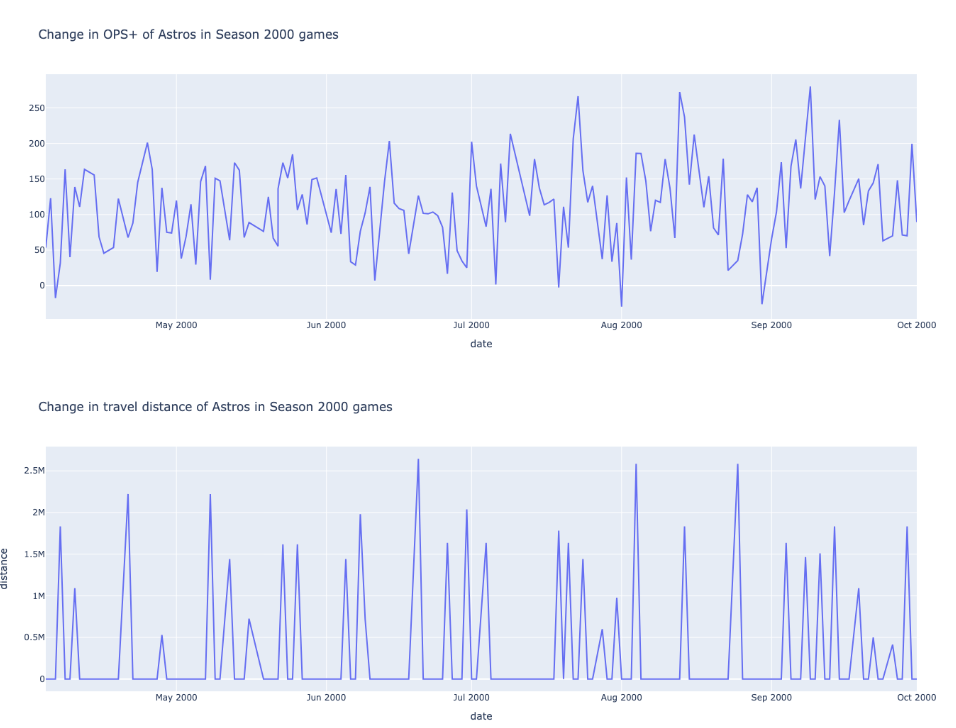

## Statistical Test and Modelling

###Preprocessing for the models

In [15]:
#Deleting 163rd column to make sure each season has same number of games total:162
ts_ops_df = ts_ops_df.drop(columns='163')
ts_dist_df = ts_dist_df.drop(columns='163')
ts_date_df = ts_date_df.drop(columns='163')

In [16]:
#Delete any seasons with many missing games
ts_ops_df = ts_ops_df.dropna()
ts_dist_df = ts_dist_df.dropna()
ts_date_df = ts_date_df.dropna()

In [17]:
#Delete the team initial and date for prediciton model
ts_ops_df = ts_ops_df.drop(columns=['0','1'])
ts_dist_df = ts_dist_df.drop(columns=['0','1'])
ts_date_df = ts_date_df.drop(columns=['0','1'])

In [18]:
ts_date_df.shape

(690, 161)

### Statistical Test: Granger Casuality Test

The **Granger Causality Test** is a statistical hypothesis test for determining whether one time series is useful in forecasting another. We chose this test to see whether the change of travel distances throughout the dates have affect on the performances on those dates. Granger Causality does not indicate causality but is a helpful measure to assess whether there is a statistical relationship between the two timeseries data.


> **Lag** refers to the number of time steps by which the time series data is shifted when assessing whether past values of one time series can predict future values of another. We set the maximum lag the test will take to 14, assuming two weeks of travel schedule may affect the game performance





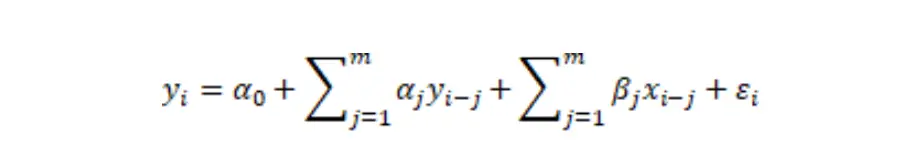



> For example, for Houston Astros Season 2000, we want to see if the two time series data below can be statistically associated


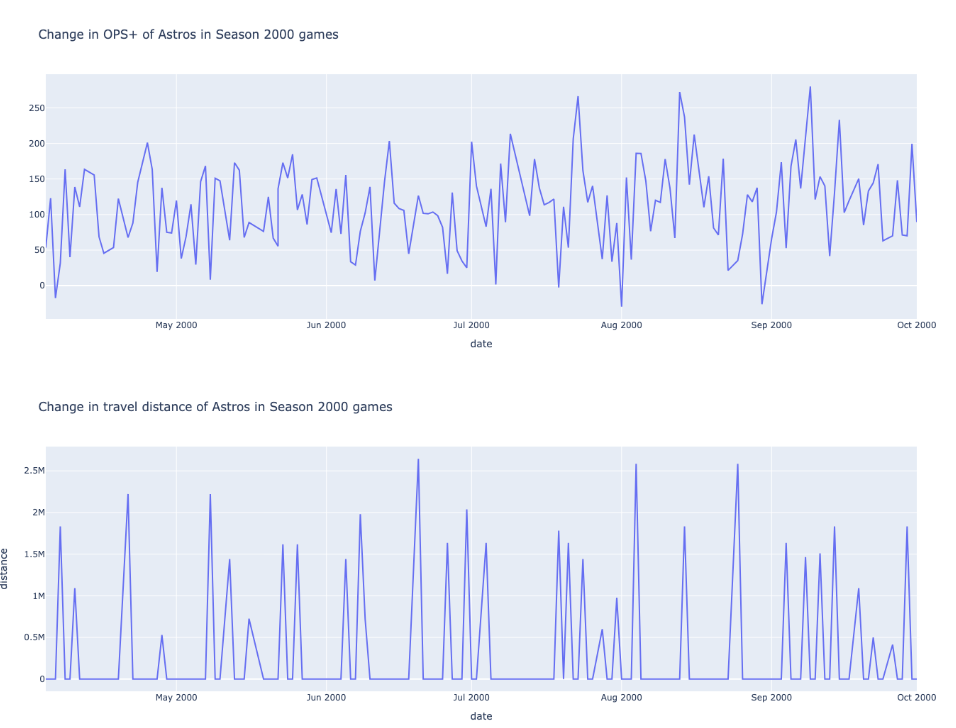

To perform the test on theses time-series data, the data need to be stationary, meaning that the time series data that mean and variance do not vary across time. This can be done using the adfuller test from statsmodels.tsa.stattools library.   

> Based on the model, p-value above 0.05 means the data is stationary



In [21]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, series_name, non_stationary_list):
    result = adfuller(series)
    #print(f'ADF Statistic for {series_name}: {result[0]}')
    #print(f'p-value for {series_name}: {result[1]}')
    if result[1] > 0.05:
        #print(f"{series_name} is not stationary")
        non_stationary_list.append(series_name)
    #else:
        #print(f"{series_name} is stationary")

non_stationary_dist_rows = []
for row_idx in range(len(ts_dist_df)):
    check_stationarity(ts_dist_df.iloc[row_idx], row_idx, non_stationary_dist_rows)

non_stationary_ops_rows = []
for row_idx in range(len(ts_ops_df)):
    check_stationarity(ts_ops_df.iloc[row_idx], row_idx, non_stationary_ops_rows)


p-value for 0: 1.2305985483410582e-06
p-value for 1: 8.722750924365366e-09
p-value for 2: 1.3545777922124672e-05
p-value for 3: 9.75846630562089e-05
p-value for 4: 0.01359691001200891
p-value for 5: 5.432161075254722e-09
p-value for 6: 1.4178899562382696e-09
p-value for 7: 0.4226239787244182
p-value for 8: 3.66083887661005e-08
p-value for 9: 0.027872807918055666
p-value for 10: 4.329186709749666e-11
p-value for 11: 0.014979584767685562
p-value for 12: 1.0132349557449879e-10
p-value for 13: 0.08954648027791251
p-value for 14: 3.960396795967605e-21
p-value for 15: 0.015141852748056043
p-value for 16: 7.61302778930052e-09
p-value for 17: 1.5061719207845552e-09
p-value for 18: 0.000269144899259608
p-value for 19: 8.725847343885422e-10
p-value for 20: 2.601581225037487e-20
p-value for 21: 0.001670268131483922
p-value for 22: 4.3208925403734043e-10
p-value for 23: 0.00024075054530815144
p-value for 24: 5.118789888390586e-06
p-value for 25: 0.025500263844780845
p-value for 26: 3.0340173672666

In [22]:
print(non_stationary_dist_rows)
print(non_stationary_ops_rows)

dropping_index = []
dropping_index.extend(non_stationary_dist_rows)
dropping_index.extend(non_stationary_ops_rows)
print(dropping_index)

[7, 13, 78, 121, 176, 308, 344, 362, 418, 420, 444, 460, 464, 465, 489, 495, 508, 568, 639, 650, 659]
[100, 163, 246, 254, 255, 257, 271, 275, 339, 508, 523, 660]
[7, 13, 78, 121, 176, 308, 344, 362, 418, 420, 444, 460, 464, 465, 489, 495, 508, 568, 639, 650, 659, 100, 163, 246, 254, 255, 257, 271, 275, 339, 508, 523, 660]


Dropping time series data that are not stationary

In [23]:
dist_rows_for_test = ts_dist_df.drop(ts_dist_df.index[dropping_index])
ops_rows_for_test = ts_ops_df.drop(ts_ops_df.index[dropping_index])
date_rows_for_test = ts_date_df.drop(ts_date_df.index[dropping_index])

In [24]:
print(len(ops_rows_for_test))

658


Since we have multiple pairing time series data, granger casuality test can be done to each of the pairing time series data, which would be the distance travelled and OPS+ for a game in a season.

In [69]:
from statsmodels.tsa.stattools import grangercausalitytests

max_lags = 14  # Set the number of lags you want to test
results = {}
sig = 0
insig = 0

for i in range(len(dist_rows_for_test)):
  test_df = pd.concat([dist_rows_for_test.iloc[i], ops_rows_for_test.iloc[i], date_rows_for_test.iloc[i]], axis=1)
  test_df.columns = ['distance', 'performance', 'date']
  test_df = test_df.set_index(test_df['date'])
  test_df = test_df.drop('date', axis=1)


  pair_name = i
  test_result = grangercausalitytests(test_df, maxlag=max_lags, verbose=False)
  test_result = test_result[1]

  params_ftest = test_result[0]['params_ftest']
  fscore, pvalue, dfnum, dfden = params_ftest

  if pvalue < 0.05:
    sig+=1
  else:
    insig+=1

  results[pair_name] = test_result

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1

In [32]:
print(sig, insig)

37 621


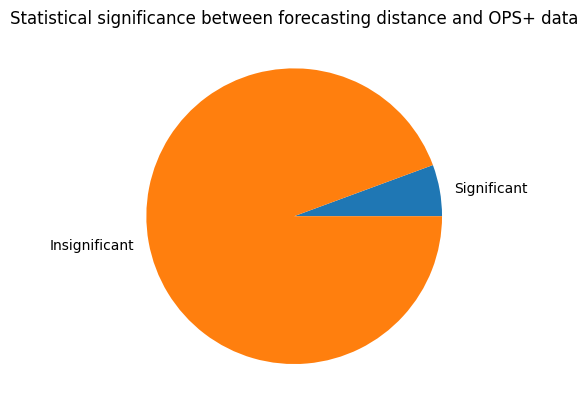

In [66]:
import matplotlib.pyplot as plt

labels = 'Significant','Insignificant'
sizes = [37, 621]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)
ax.title.set_text('Statistical significance between forecasting distance and OPS+ data')


>According to the results, there are 37 travel distance timeseries datasets that can be statistically used to predict the OPS+ level. However, 621 are statistically insignificant. Since there are much more statistically insignificant timeseries pair, we can conclude that the travelled distance is a statistically insignificant measure for predicting the performance level of a MLB team.




##LSTM

In [ ]:
#Changing ops data for lstm
new_ts_ops_df = pd.DataFrame()

sample_size, segments = ts_ops_df.shape

new_rows = []

for i in range(sample_size):
    sample = ts_ops_df.iloc[i]
    for j in range(segments - 20 + 1):
        new_rows.append(sample[j:j+20].values)

new_ts_ops_df = pd.DataFrame(new_rows)
print(new_ts_ops_df.shape)

In [ ]:
#Changing distance for lstm
new_ts_dist_df = pd.DataFrame()

sample_size, segments = ts_dist_df.shape

new_rows = []

for i in range(sample_size):
    sample = ts_dist_df.iloc[i]
    for j in range(segments - 20 + 1):
        new_rows.append(sample[j:j+20].values)

new_ts_dist_df = pd.DataFrame(new_rows)
print(new_ts_dist_df.shape)

In [26]:
np_performance = new_ts_ops_df.to_numpy()
np_distance = new_ts_dist_df.to_numpy()

In [27]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [28]:
# Normalize performance data by dividing by 100
normalized_performance = np_performance / 100.0

# Ensure it's a 2D numpy array
normalized_performance = normalized_performance.reshape(-1, np_performance.shape[1])
normalized_performance = normalized_performance.astype(np.float32)

# Fit and scale distance data
scaler_distance = MinMaxScaler(feature_range=(0, 1))
scaled_distance = scaler_distance.fit_transform(np_distance)

# Ensure scaled_distance is a 2D numpy array
scaled_distance = scaled_distance.reshape(-1, np_distance.shape[1])


combined_data = np.stack((normalized_performance, scaled_distance), axis=-1)  # Shape: [n, 162, 2]
normalized_performance.shape, scaled_distance.shape


((97980, 20), (97980, 20))

In [29]:
class TimeseriesDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming the last value is what you want to predict
        return self.data[idx, :-1, :], self.data[idx, -1, 0]

dataset = TimeseriesDataset(torch.from_numpy(combined_data).float())


train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    for sequences, labels in train_loader:
        # Move data to GPU
        sequences, labels = sequences.to(device), labels.to(device)

    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])  # We use the last time-step output for prediction
        return predictions

model = LSTMModel(input_size=2, hidden_layer_size=100, output_size=1)
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(20):
    for sequences, labels in train_loader:
        # Move data to GPU
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        y_pred = model(sequences)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1} Loss: {loss.item()}')


Epoch 1 Loss: 0.3582223951816559
Epoch 2 Loss: 0.32976898550987244
Epoch 3 Loss: 0.35985973477363586
Epoch 4 Loss: 0.2912578582763672
Epoch 5 Loss: 0.3542497456073761
Epoch 6 Loss: 0.2944457530975342
Epoch 7 Loss: 0.229509174823761
Epoch 8 Loss: 0.2825898230075836
Epoch 9 Loss: 0.259609580039978
Epoch 10 Loss: 0.20717716217041016
Epoch 11 Loss: 0.2949606478214264
Epoch 12 Loss: 0.25637757778167725
Epoch 13 Loss: 0.33077868819236755
Epoch 14 Loss: 0.3558975160121918
Epoch 15 Loss: 0.348580926656723
Epoch 16 Loss: 0.41999489068984985
Epoch 17 Loss: 0.38362184166908264
Epoch 18 Loss: 0.3188959062099457
Epoch 19 Loss: 0.3908771276473999
Epoch 20 Loss: 0.2956632971763611


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for sequences, labels in test_loader:
            # Move data to GPU
            sequences = sequences.to(device)

            y_pred = model(sequences)
            predictions.extend(y_pred.cpu().squeeze().numpy())
            actuals.extend(labels.cpu().numpy())

    return predictions, actuals

predictions, actuals = evaluate_model(model, test_loader)

# Adjust predictions back to original performance scale by multiplying by 100
original_predictions = np.array(predictions) * 100

# Assuming actuals are already in the original scale
original_actuals = np.array(actuals) * 100

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(original_actuals, original_predictions)
mse = mean_squared_error(original_actuals, original_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(original_actuals, original_predictions)

print(f"Original Scale - MAE: {mae}")
print(f"Original Scale - MSE: {mse}")
print(f"Original Scale - RMSE: {rmse}")
print(f"Original Scale - R² Score: {r2}")

Original Scale - MAE: 47.12430191040039
Original Scale - MSE: 3470.30908203125
Original Scale - RMSE: 58.90932846069336
Original Scale - R² Score: 0.011462587352991882
